# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [1]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn
import psycopg2 as psy

#### Step 2: Examine your data 

In [2]:
# Examine airport data and import from csv
airport = pd.read_csv('../assets/airports.csv')
airport.head(3)

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes


In [3]:
# shape of airport shape
airport.shape

(5167, 13)

In [4]:
# Examine and import airport operations data
airport_op = pd.read_csv('../assets/Airport_operations.csv')
airport_op.head()


,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [5]:
# shape of airport operations shape
airport_op.shape

(841, 15)

In [6]:
# Examine and import airport cancellations data
airport_can = pd.read_csv('../assets/airport_cancellations.csv')
airport_can.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [7]:
# shape of airport operations shape
airport_can.shape

(805, 6)

### Intro: Write a problem statement / aim for this project

You've been hired by the FAA as a consultant to analyze the operations of major airports around the country. The FAA wants to cut down on delays nationwide, and the most important part of this task is understanding the characteristics and groupings of airports based on a dataset of departure and operational delays.

A certain degree of delay is expected in airport operations, however the FAA is noticing significant delays with certain airports
When a flight takes off, it's departure delay is recorded in minutes, as well as operational data relating to this delay
At the end of the year, this data is averaged out for each airport. Your datasets have these averaged for a 10 year range between 2004 and 2014
Over this 10 year range, some delay times have not improved or have worsened.

Objective: Your task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [8]:
from sqlalchemy import create_engine

In [9]:
# load sql
%load_ext sql

In [10]:
# connect to postgresql
%sql postgresql://student@localhost:5432/airport

u'Connected: student@airport'

In [11]:
# create engine
engine = create_engine('postgresql://student@localhost:5432/airport')

Load our csv files into tables

In [12]:
# create airport, airport_cancellations, airport_operations tables
airport.to_sql('airport',engine,if_exists='replace')
airport_can.to_sql('airport_cancellations',engine,if_exists='replace')
airport_op.to_sql('airport_operations',engine,if_exists='replace')

Join airport_cancellations.csv and airports.csv into one table

In [13]:
# Combine cancellations,airports, and airport operations tables in Postgresql
airports  = %%sql select * from airport a join airport_cancellations ac on a."LocID" = ac."Airport" join airport_operations ao on (a."LocID"=ao."airport" and ac."Year" = ao."year")

799 rows affected.


## Clean & Format Data

In [14]:
# Convert to dataframe
airports = airports.DataFrame()

In [15]:
# drop index
airports.drop('index',axis=1,inplace=True)

Query the database for our intial data

In [16]:
# Number of unique airports
airports['LocID'].nunique()

74

In [17]:
# All airports with cancellation information
airports['AP_NAME'].unique()

array([u'LUIS MUNOZ MARIN INTL', u'KAHULUI', u'HONOLULU INTL',
       u'MIAMI INTL', u'FORT LAUDERDALE/HOLLYWOOD INTL',
       u'SOUTHWEST FLORIDA INTL', u'PALM BEACH INTL', u'TAMPA INTL',
       u'ORLANDO INTL', u'SAN ANTONIO INTL', u'WILLIAM P HOBBY',
       u'GEORGE BUSH INTERCONTINENTAL/HOUSTON',
       u'LOUIS ARMSTRONG NEW ORLEANS INTL', u'AUSTIN-BERGSTROM INTL',
       u'JACKSONVILLE INTL', u'TUCSON INTL', u'SAN DIEGO INTL',
       u'DALLAS LOVE FIELD', u'DALLAS/FORT WORTH INTL',
       u'PHOENIX SKY HARBOR INTL', u'BIRMINGHAM-SHUTTLESWORTH INTL',
       u'HARTSFIELD - JACKSON ATLANTA INTL',
       u'JOHN WAYNE AIRPORT-ORANGE COUNTY',
       u'LONG BEACH /DAUGHERTY FIELD/', u'PALM SPRINGS INTL',
       u'LOS ANGELES INTL', u'ONTARIO INTL', u'BOB HOPE', u'OXNARD',
       u'ALBUQUERQUE INTL SUNPORT', u'MEMPHIS INTL',
       u'CHARLOTTE/DOUGLAS INTL', u'RALEIGH-DURHAM INTL',
       u'MC CARRAN INTL', u'NASHVILLE INTL',
       u'NORMAN Y. MINETA SAN JOSE INTL', u'SAN FRANCISCO INTL'

In [18]:
# drop alias, facility type, key, airport x2, year columns
airports = airports.drop(['ALIAS','Facility Type','Key','Airport','airport','year','Boundary Data Available','COUNTY'],axis=1)

In [19]:
# type (class) of columns
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 26 columns):
LocID                                 799 non-null object
AP_NAME                               799 non-null object
FAA REGION                            799 non-null object
CITY                                  799 non-null object
STATE                                 799 non-null object
AP Type                               799 non-null object
Latitude                              799 non-null float64
Longitude                             799 non-null float64
Year                                  799 non-null float64
Departure Cancellations               799 non-null float64
Arrival Cancellations                 799 non-null float64
Departure Diversions                  799 non-null float64
Arrival Diversions                    799 non-null float64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate

In [20]:
# make column titles lowercase
airports.columns = [x.lower() for x in airports.columns]

In [21]:
# Check for nulls
airports.isnull().sum()

locid                                 0
ap_name                               0
faa region                            0
city                                  0
state                                 0
ap type                               0
latitude                              0
longitude                             0
year                                  0
departure cancellations               0
arrival cancellations                 0
departure diversions                  0
arrival diversions                    0
departures for metric computation     0
arrivals for metric computation       0
percent on-time gate departures       0
percent on-time airport departures    0
percent on-time gate arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0
average taxi out delay                0
average airport departure delay       0
average airborne delay                0
average taxi in delay                 0
average block delay                   0


#### 1.2 What are the risks and assumptions of our data? 

The risk and assumptions of the data is


## Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
# Describe the data
airports.describe()

,latitude,longitude,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,36.448807,-94.899998,2009.016270,1299.314143,1341.068836,174.250313,170.256571,113471.568210,113003.959950,0.779123,0.726958,0.766864,12.890250,13.872879,3.683292,15.703504,2.875532,1.414155,3.290826,13.428811
std,6.686781,20.644996,3.150126,1840.877193,1980.459892,172.638408,229.162686,98059.144667,97705.308115,0.052279,0.076027,0.050502,3.036474,3.806217,2.337325,4.364217,1.169739,0.854702,0.989275,3.251647
min,18.439295,-157.922429,2004.000000,0.000000,0.000000,0.000000,0.000000,731.000000,717.000000,0.529900,0.380800,0.513600,5.350000,7.240000,0.100000,6.290000,0.950000,0.020000,1.330000,6.330000
25%,32.896828,-111.977773,2006.000000,349.000000,314.500000,62.000000,41.000000,42064.000000,42006.500000,0.753100,0.691800,0.742150,10.830000,11.475000,2.300000,12.890000,2.035000,0.845000,2.615000,11.270000
50%,37.618972,-87.897068,2009.000000,670.000000,653.000000,111.000000,84.000000,79489.000000,79750.000000,0.784100,0.740200,0.770500,12.540000,12.940000,3.050000,15.130000,2.620000,1.140000,3.130000,12.970000
75%,40.795250,-80.152741,2012.000000,1483.500000,1542.000000,237.000000,190.000000,166469.500000,165560.500000,0.810700,0.773700,0.797600,14.620000,15.745000,4.220000,17.555000,3.550000,1.775000,3.815000,14.935000
max,61.174083,-66.002004,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000


In [24]:
# Top airports with the highest yearly departue & arrival cancellations
tydc = airports[['locid','year','departure cancellations']].sort_values('departure cancellations', ascending = False)
tydc = pd.DataFrame(tydc)

tyac = airports[['locid','year','arrival cancellations']].sort_values('arrival cancellations', ascending = False)
tyac = pd.DataFrame(tyac)

In [25]:
tydc.head()

,locid,year,departure cancellations
690,ORD,2007.0,16618.0
689,ORD,2008.0,15050.0
240,ATL,2005.0,13837.0
683,ORD,2014.0,13454.0
691,ORD,2006.0,12915.0


In [26]:
tyac.head()

,locid,year,arrival cancellations
690,ORD,2007.0,17571.0
689,ORD,2008.0,16094.0
240,ATL,2005.0,14480.0
683,ORD,2014.0,14355.0
691,ORD,2006.0,13808.0


Orlando has the highest cancellations among all airports throughout multiple years

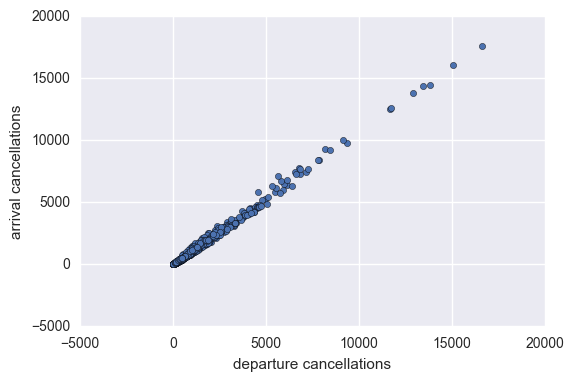

In [27]:
# relationship between departure and arrival cancellations

airports.plot(kind='scatter', x='departure cancellations', y='arrival cancellations')

There is a positive correlation between arrival and departure cancellations

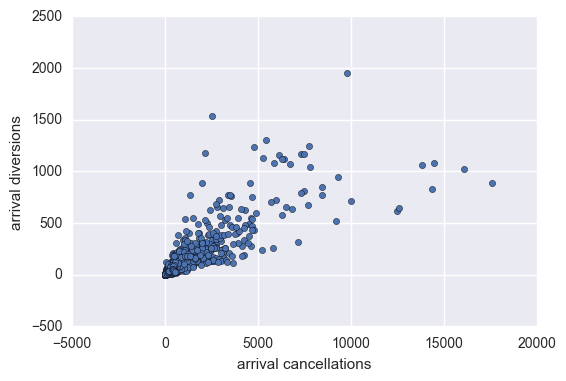

In [28]:
# relationship between arrival cancellations and arrival diversions

airports.plot(kind='scatter', x='arrival cancellations', y='arrival diversions')

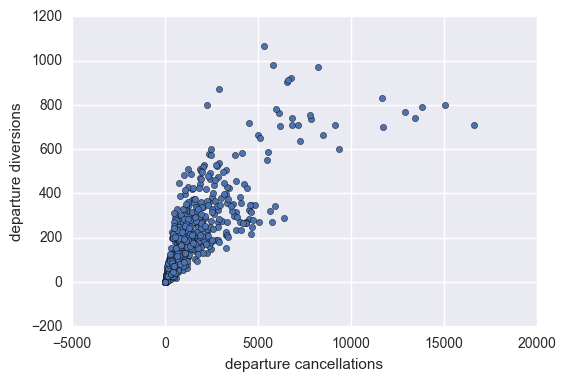

In [29]:
# relationship between departure cancellations and departure diversions

airports.plot(kind='scatter', x='departure cancellations', y='departure diversions')

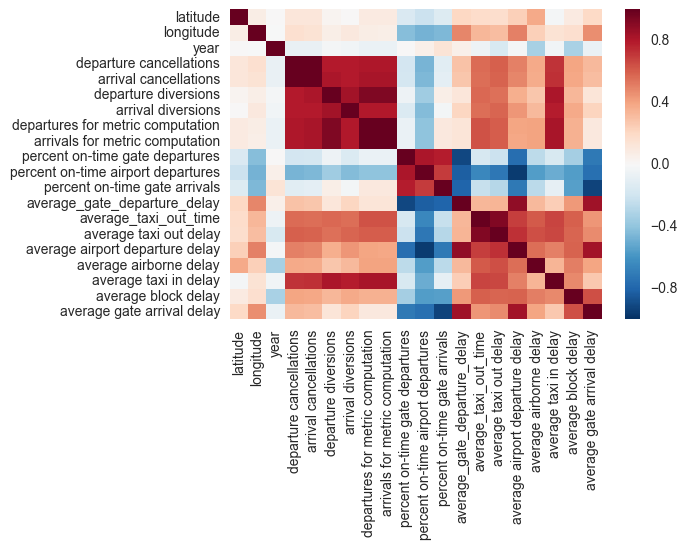

In [30]:
# correlation heatmap of features
sns.heatmap(airports.corr());

As previously shown in scatterplots, both arrival and departure cancellations and diversions are highly correlated. Also, percent on time gate departurs and arrivals are also correlated for airports. 

This may indicate that airports with delay problems consistently have high delays while airports with on time departures consistently have on time departures. 

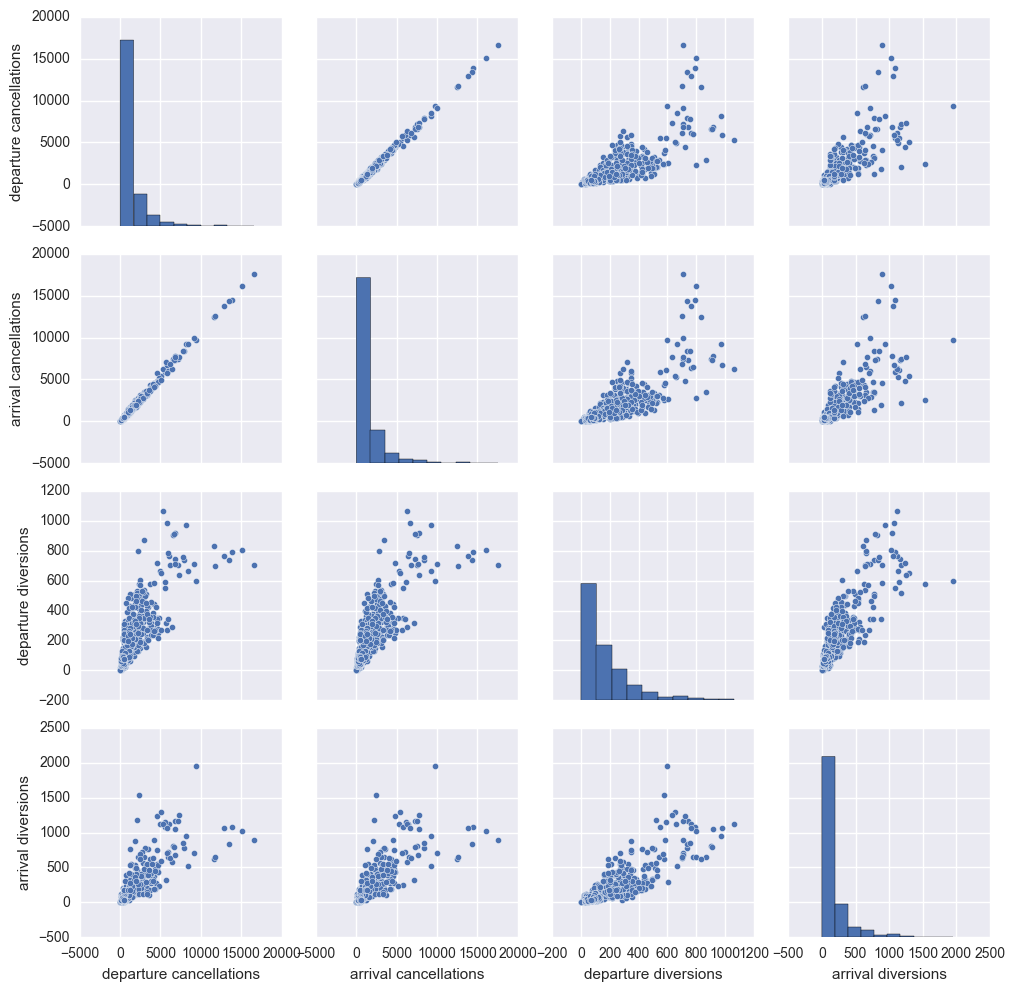

In [31]:
# pairplot departure & arrival cancellations & diversions
sns.pairplot(airports.iloc[:,9:13])

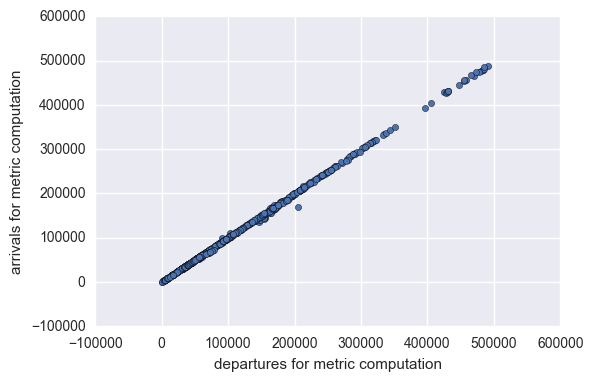

In [32]:
#relationship of departures vs arrivals (for metric computation)
airports.plot(kind='scatter', x='departures for metric computation', y='arrivals for metric computation')

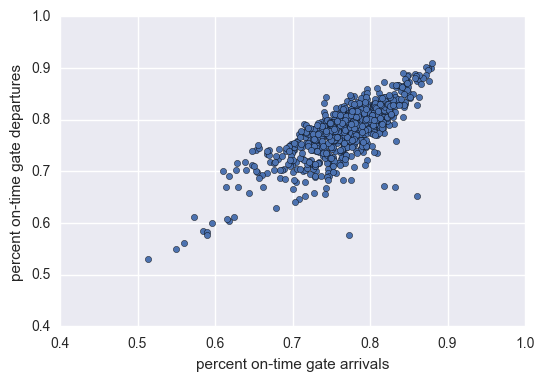

In [33]:
# percent on time gate arrivals vs percent on time gate departures
airports.plot(kind='scatter', x='percent on-time gate arrivals', y='percent on-time gate departures')

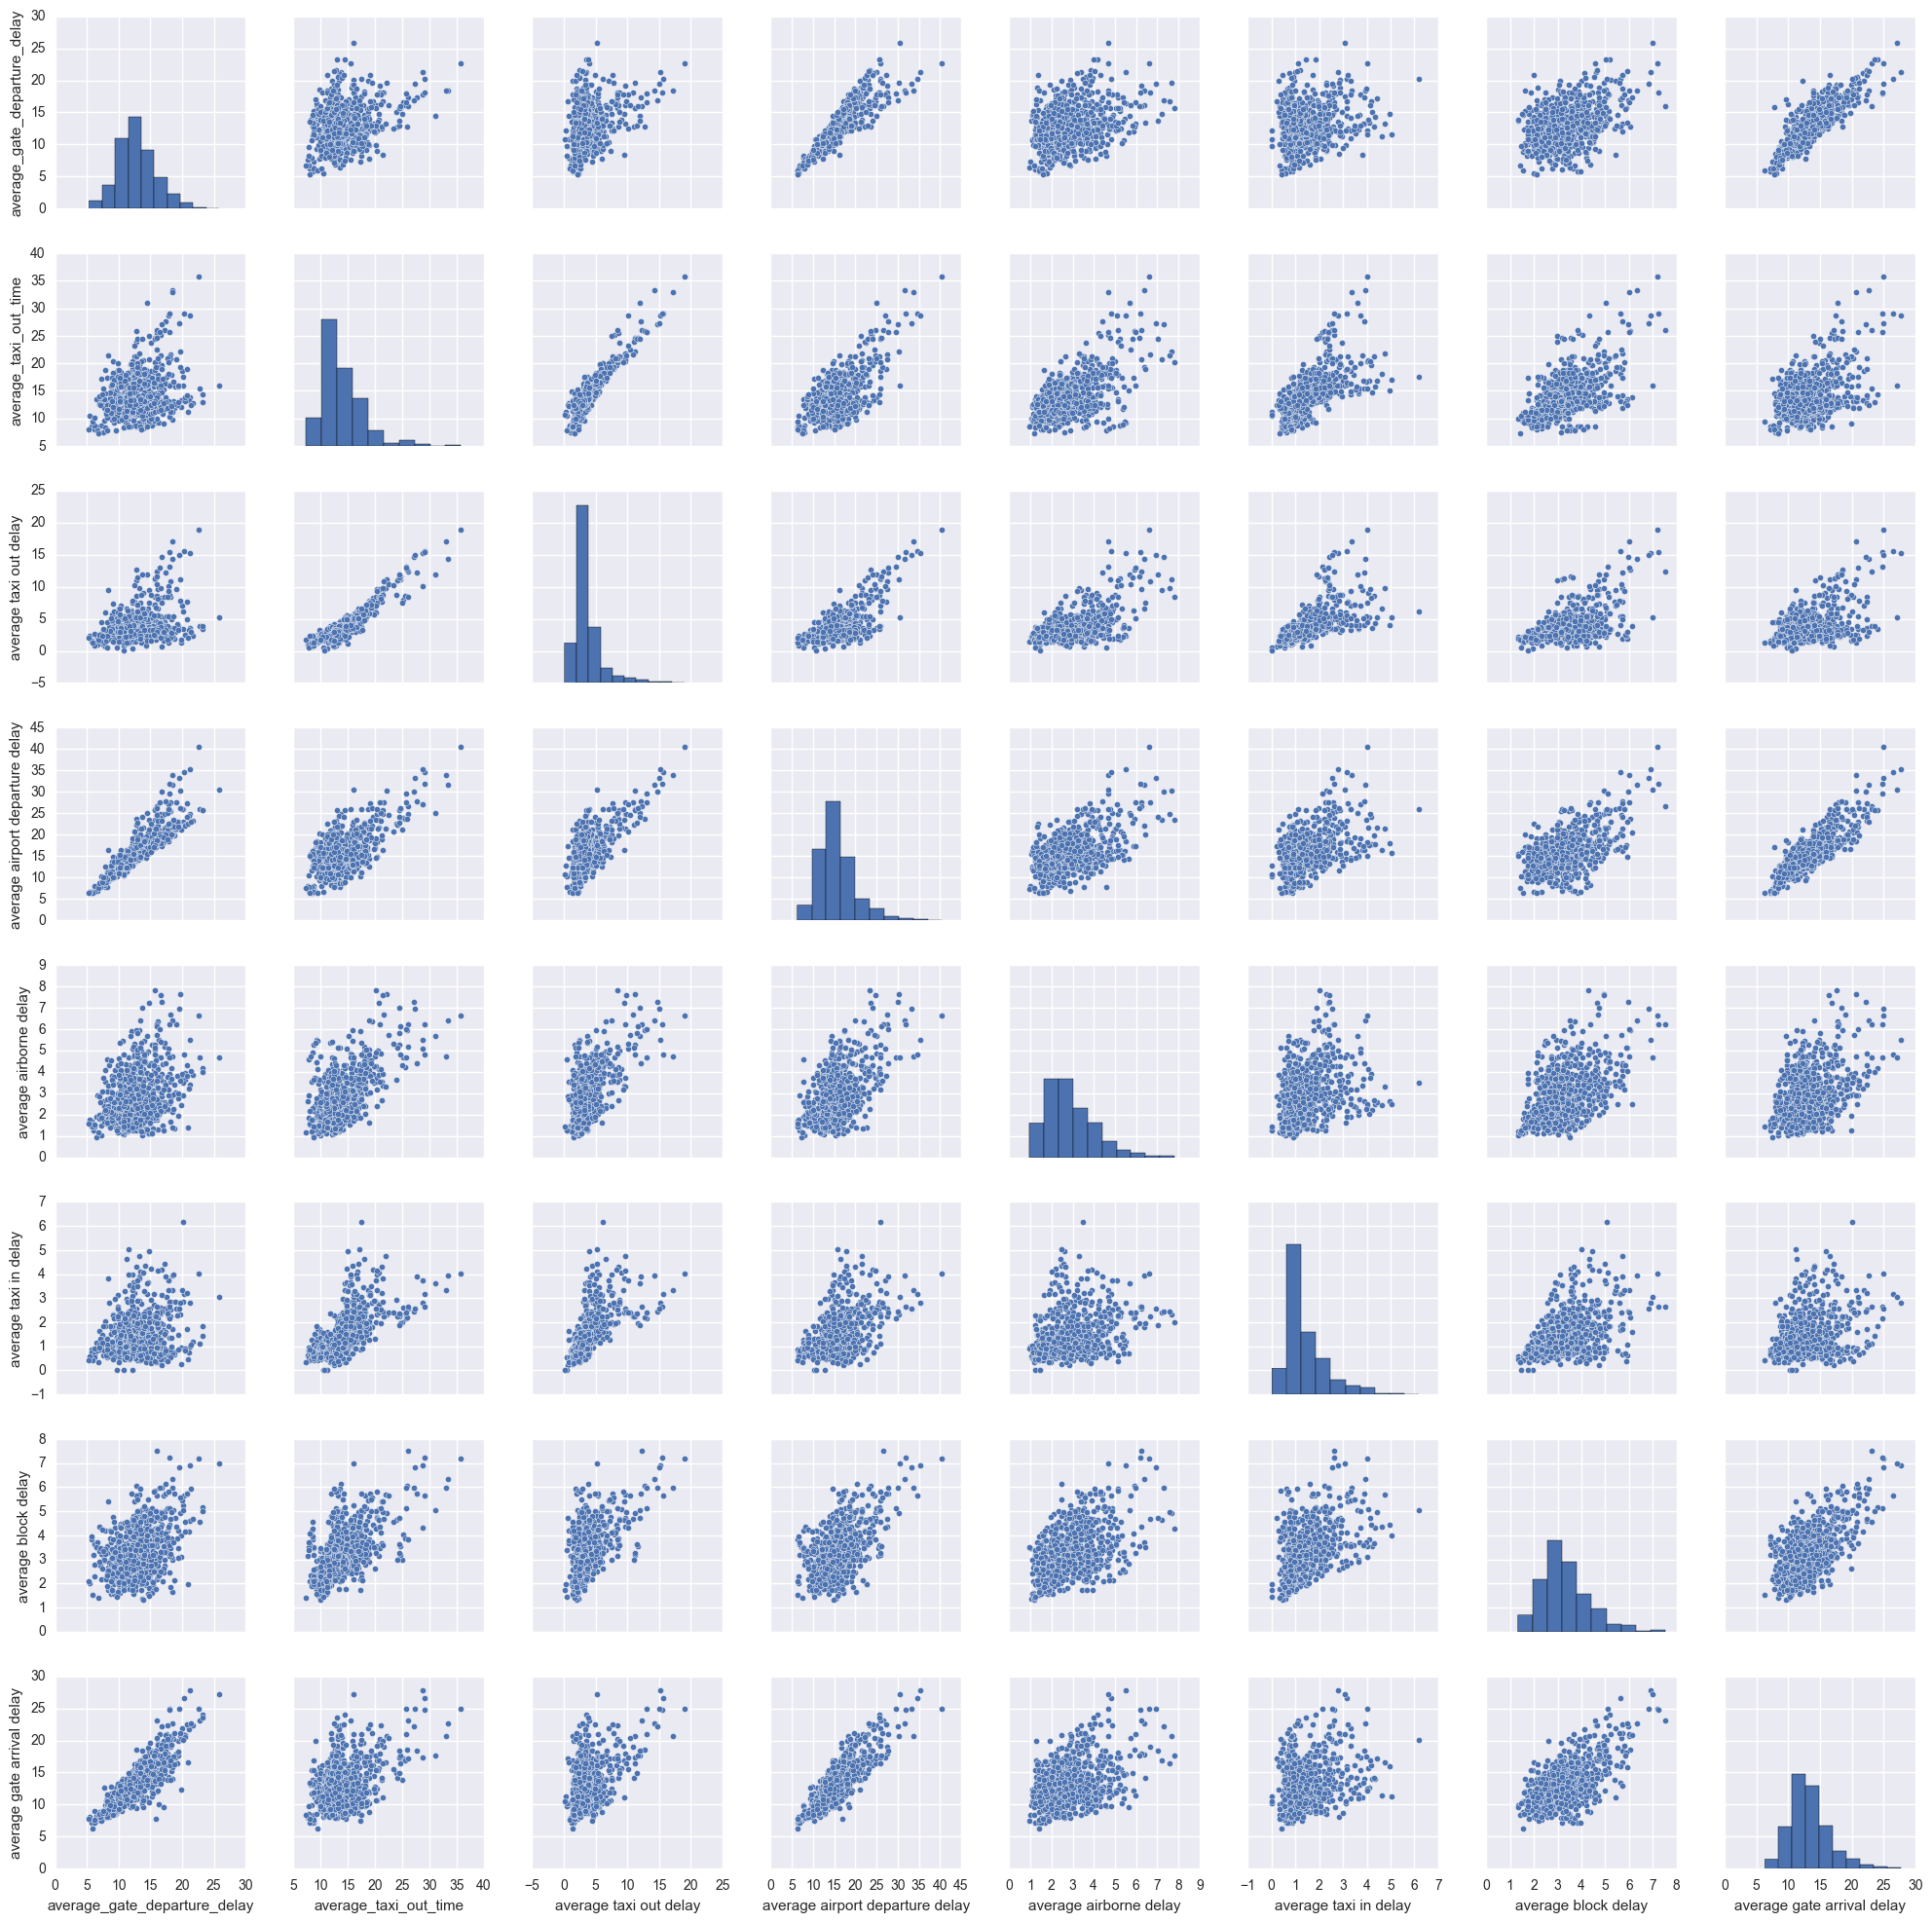

In [34]:
# pairplot of airports operations
sns.pairplot(airports.iloc[:,18:26])

In [35]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

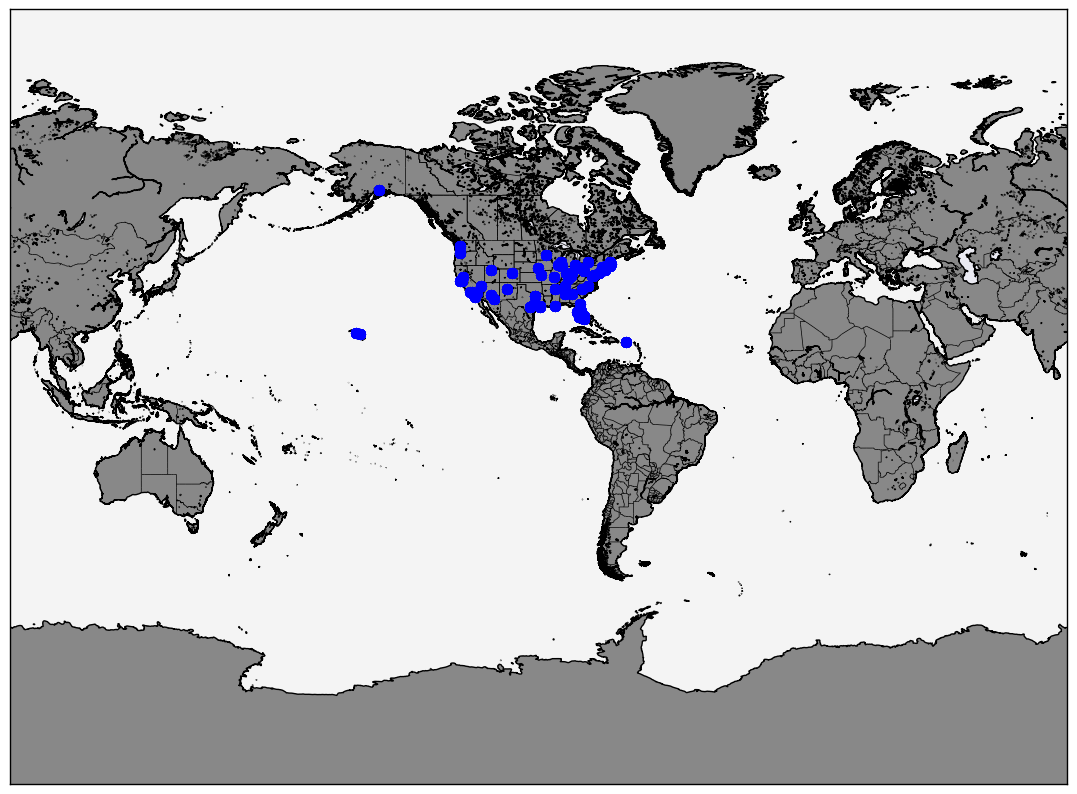

In [36]:
# Create a figure of size
fig = plt.figure(figsize=(20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(projection='mill',
              #resolution = high
              resolution = 'h',
              # And threshold 1000
              area_thresh = 10.0,
              # Centered at(USA)
              lat_0=37.0902, lon_0=-95.7129)

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()

# Draw States
map.drawstates()

# Fill the land with grey
map.fillcontinents(color = '#888888')

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')

# Define our longitude and latitude points
x,y = map(airports['longitude'].values, airports['latitude'].values)

# Plot them using round markers of size 8
map.plot(x, y, 'bo', markersize=8)

# Show the map
plt.show()

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [78]:
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.preprocessing import LabelEncoder

In [79]:
airports.T

,0,1,2,3,4,5,6,7,8,9,...,789,790,791,792,793,794,795,796,797,798
locid,SJU,SJU,SJU,SJU,SJU,SJU,SJU,SJU,SJU,SJU,...,ANC,ANC,ANC,ANC,ANC,ANC,ANC,ANC,ANC,ANC
ap_name,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,LUIS MUNOZ MARIN INTL,...,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL,TED STEVENS ANCHORAGE INTL
faa region,ASO,ASO,ASO,ASO,ASO,ASO,ASO,ASO,ASO,ASO,...,AAL,AAL,AAL,AAL,AAL,AAL,AAL,AAL,AAL,AAL
city,SAN JUAN,SAN JUAN,SAN JUAN,SAN JUAN,SAN JUAN,SAN JUAN,SAN JUAN,SAN JUAN,SAN JUAN,SAN JUAN,...,ANCHORAGE,ANCHORAGE,ANCHORAGE,ANCHORAGE,ANCHORAGE,ANCHORAGE,ANCHORAGE,ANCHORAGE,ANCHORAGE,ANCHORAGE
state,PR,PR,PR,PR,PR,PR,PR,PR,PR,PR,...,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK
ap type,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,...,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial,Federalized/Commercial
latitude,18.4393,18.4393,18.4393,18.4393,18.4393,18.4393,18.4393,18.4393,18.4393,18.4393,...,61.1741,61.1741,61.1741,61.1741,61.1741,61.1741,61.1741,61.1741,61.1741,61.1741
longitude,-66.002,-66.002,-66.002,-66.002,-66.002,-66.002,-66.002,-66.002,-66.002,-66.002,...,-149.998,-149.998,-149.998,-149.998,-149.998,-149.998,-149.998,-149.998,-149.998,-149.998
year,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,...,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004
departure cancellations,280,127,174,240,258,199,238,307,257,315,...,141,216,191,149,354,268,359,367,424,473


In [80]:
airports['label_faa'] = LabelEncoder().fit_transform(airports['faa region'])

In [81]:
x = airports.iloc[:,6:]

In [82]:
Xstand = StandardScaler().fit_transform(x)

In [83]:
covMat = np.cov(Xstand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [84]:
print eigenValues

[  9.48373201e+00   4.48787191e+00   1.66324129e+00   1.36129446e+00
   9.19527740e-01   7.79775012e-01   5.98712665e-01   4.06168733e-01
   3.20890743e-01   2.47768893e-01   2.11189664e-01   1.67765552e-01
   1.56250530e-01   9.61116983e-02   5.95929348e-02   4.65585132e-02
   1.31705894e-02   4.00377740e-03   1.57824329e-03   9.42407059e-04
   1.68424397e-04]


In [85]:
print eigenVectors

[[  7.71599255e-02  -1.04148996e-01  -5.33991821e-01   3.31699955e-01
    3.78806253e-01  -2.58383045e-01   2.46377876e-02   7.27533977e-02
   -4.01973813e-01   4.74206540e-02  -2.71745090e-01  -1.43439943e-01
   -2.46448889e-01   2.08808411e-01  -2.26467307e-02   8.91238308e-02
    2.73428544e-02  -5.24643441e-03  -6.04488514e-03  -3.57269862e-03
   -8.23053677e-04]
 [  1.33924072e-01  -2.03895419e-01  -3.86512687e-02   2.04068375e-01
   -3.78737044e-01   7.30946926e-01  -2.35680067e-02   6.73956730e-02
   -9.17856254e-03   1.26001936e-01  -2.49362943e-01  -1.13553852e-01
   -2.80075558e-01   1.48727212e-01  -5.92572895e-02   1.34719910e-01
    3.44872974e-02  -8.43084816e-03   2.59227583e-03   1.46043487e-03
   -1.00816896e-03]
 [ -3.95087529e-02   3.86425642e-03   2.15340243e-01   6.45953603e-01
   -3.58990383e-01  -4.50554211e-01  -1.83110868e-01  -4.22588125e-02
    3.24494445e-01   8.13902784e-02  -1.33365915e-01  -5.44156554e-02
   -1.30469821e-01  -1.08286803e-01  -1.53846872e-

In [86]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

9.48373200561
4.48787190616
1.6632412937
1.36129446489
0.919527739548
0.77977501168
0.598712665001
0.406168732756
0.320890743406
0.247768893247
0.211189664497
0.167765551612
0.156250529544
0.0961116982727
0.059592934796
0.0465585131969
0.0131705894143
0.00400377739792
0.00157824328846
0.00094240705874
0.000168424396843


In [87]:
totalEigen = sum(eigenValues)
varExpl = [(i/totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

In [88]:
print cumulvarExpl

[  45.10410716   66.4481788    74.3584628    80.83270431   85.20592761
   88.91449462   91.76193909   93.69365521   95.21979392   96.39816913
   97.40257554   98.20045927   98.94357818   99.40068012   99.68410084
   99.90553057   99.96816916   99.98721091   99.99471695   99.99919898
  100.        ]


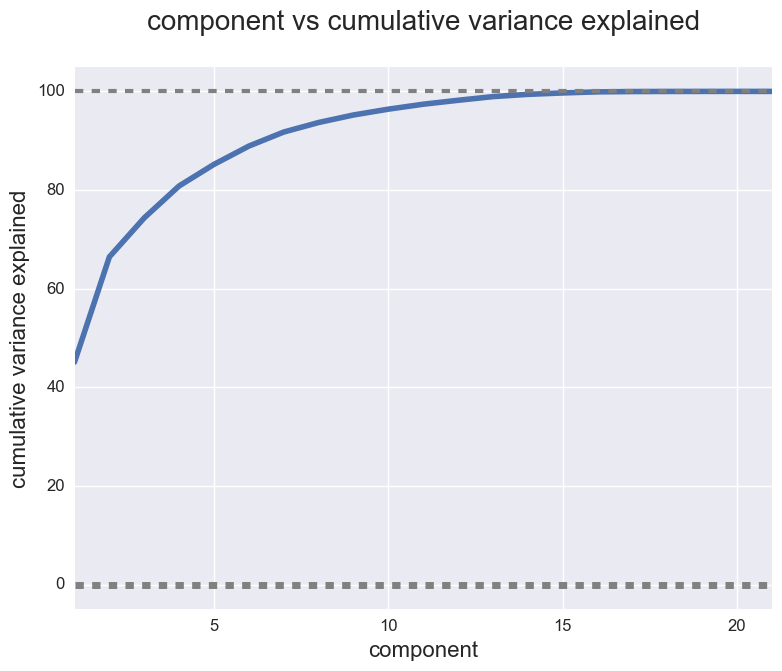

In [89]:
plt.figure(figsize=(9,7))

component_number = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

plt.plot(component_number, cumulvarExpl, lw=4)

plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')


ax = plt.gca()
ax.set_xlim([1,21])
ax.set_ylim([-5,105])

ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

In [90]:
airports_pca = PCA(n_components=2)
X = airports_pca.fit_transform(Xstand)

In [91]:
Xt = pd.DataFrame(X, columns=['PC1','PC2'])
Xt.head()

,PC1,PC2
0,-2.321683,0.230705
1,-2.083273,0.196549
2,-3.146930,-0.963605
3,-2.214403,-0.270500
4,-1.966639,0.378960


In [92]:
a_faa = LabelEncoder().fit_transform(airports['faa region'])

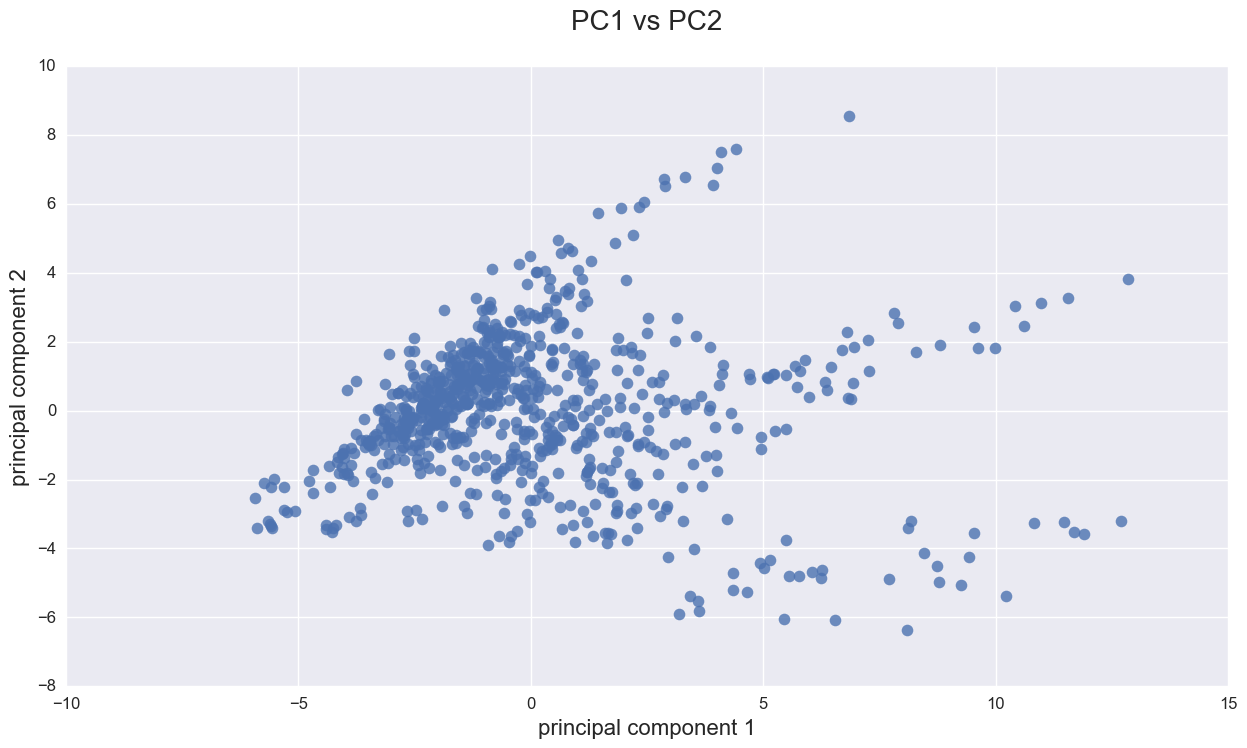

In [93]:
fig = plt.figure(figsize=(15,8))

ax = fig.gca()
ax = sns.regplot(Xt.iloc[:,0], Xt.iloc[:,1],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=20)

plt.show()

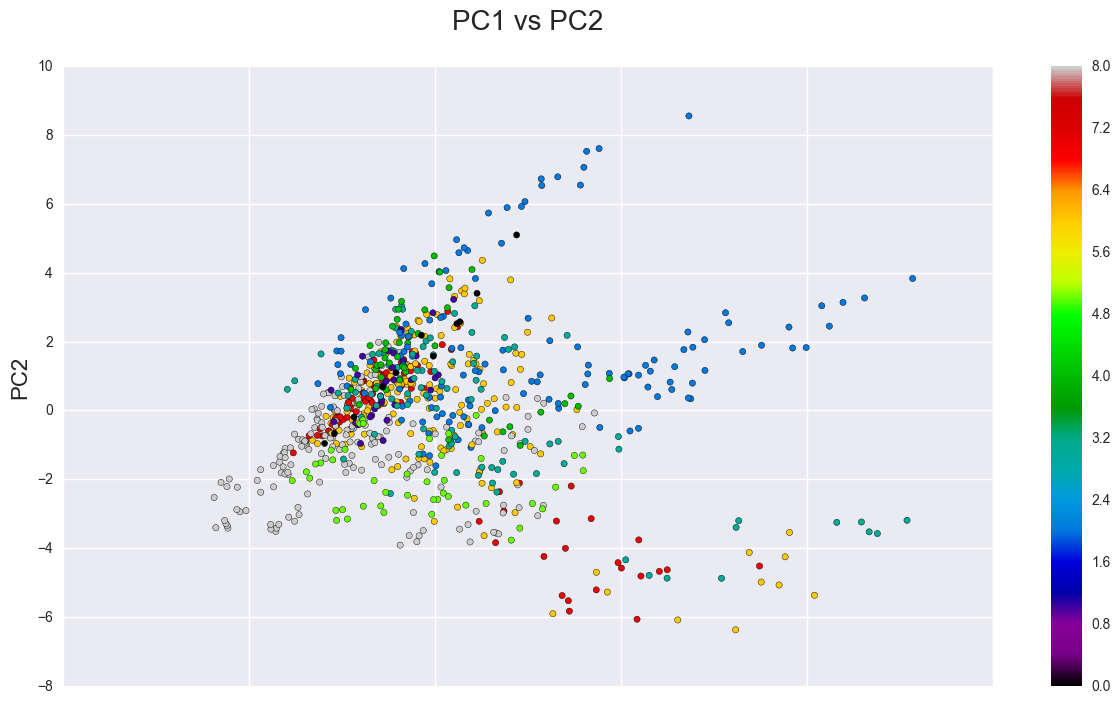

In [94]:
plt.figure(figsize = (10,8))
ax = Xt.plot.scatter('PC1', 'PC2', c = a_faa, figsize = (15,8), cmap = 'nipy_spectral')
ax.set_title('PC1 vs PC2\n', fontsize=20)
ax.set_xlabel('PC1', fontsize=16)
ax.set_ylabel('PC2', fontsize=16);

In [95]:
airports_pca3 = PCA(n_components=3)
X3 = airports_pca3.fit_transform(Xstand)

In [96]:
Xt3 = pd.DataFrame(X3, columns=['PC1','PC2','PC3'])
Xt3.head()

,PC1,PC2,PC3
0,-2.321683,0.230705,-1.822910
1,-2.083273,0.196549,-1.815123
2,-3.146930,-0.963605,-1.230003
3,-2.214403,-0.270500,-1.580571
4,-1.966639,0.378960,-1.780240


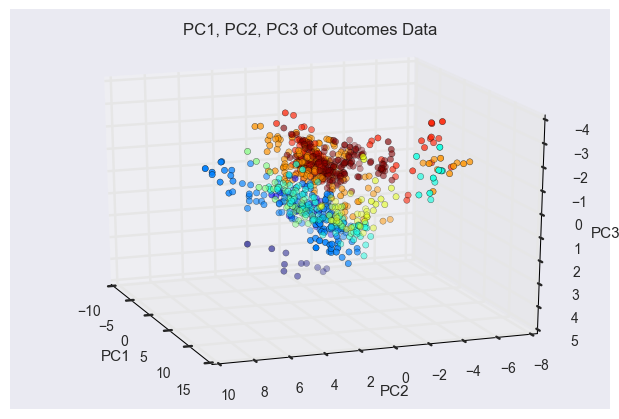

In [97]:
from mpl_toolkits.mplot3d import Axes3D

plt.close('all')
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.scatter(xs = Xt3['PC1'], ys = Xt3['PC2'], zs = Xt3['PC3'], c = a_faa, cmap='jet')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PC1, PC2, PC3 of Outcomes Data')

ax.azim = 200
ax.elev = 199

plt.show()

## KMEANS

In [98]:
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets, preprocessing, metrics

In [99]:
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(Xt3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [100]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_

In [101]:
centroids

array([[ 0.19263362,  1.75208727, -0.25281427],
       [-1.96430144, -0.79590686,  0.17193848],
       [ 5.25231541, -1.49891247,  0.05148728]])

In [102]:
inertia

5908.6409650564547

In [103]:
metrics.silhouette_score(Xt3, labels, metric='euclidean')

0.27525709250633246

In [104]:
a_id = LabelEncoder().fit_transform(airports['locid'])

In [105]:
Xt['cluster']= pd.Series(labels)

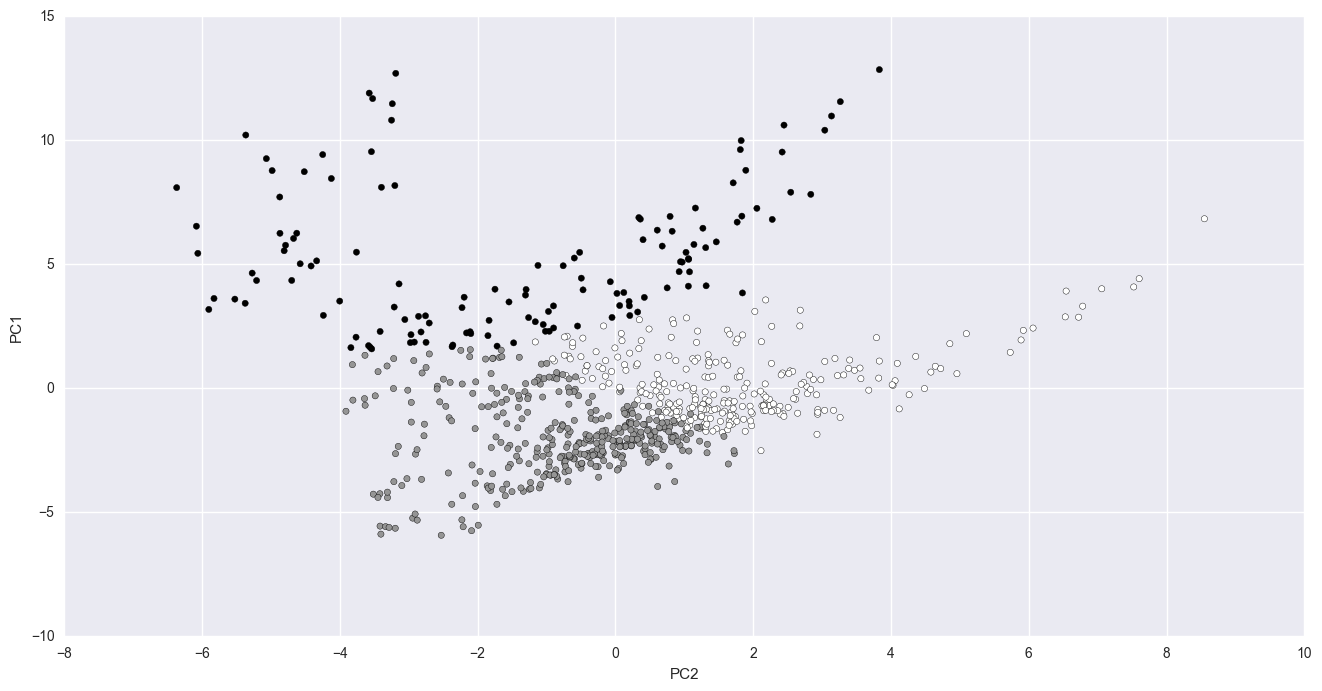

In [106]:
Xt.plot(kind='scatter', x='PC2',y='PC1', c=Xt.cluster.astype(np.float),figsize=(16,8))

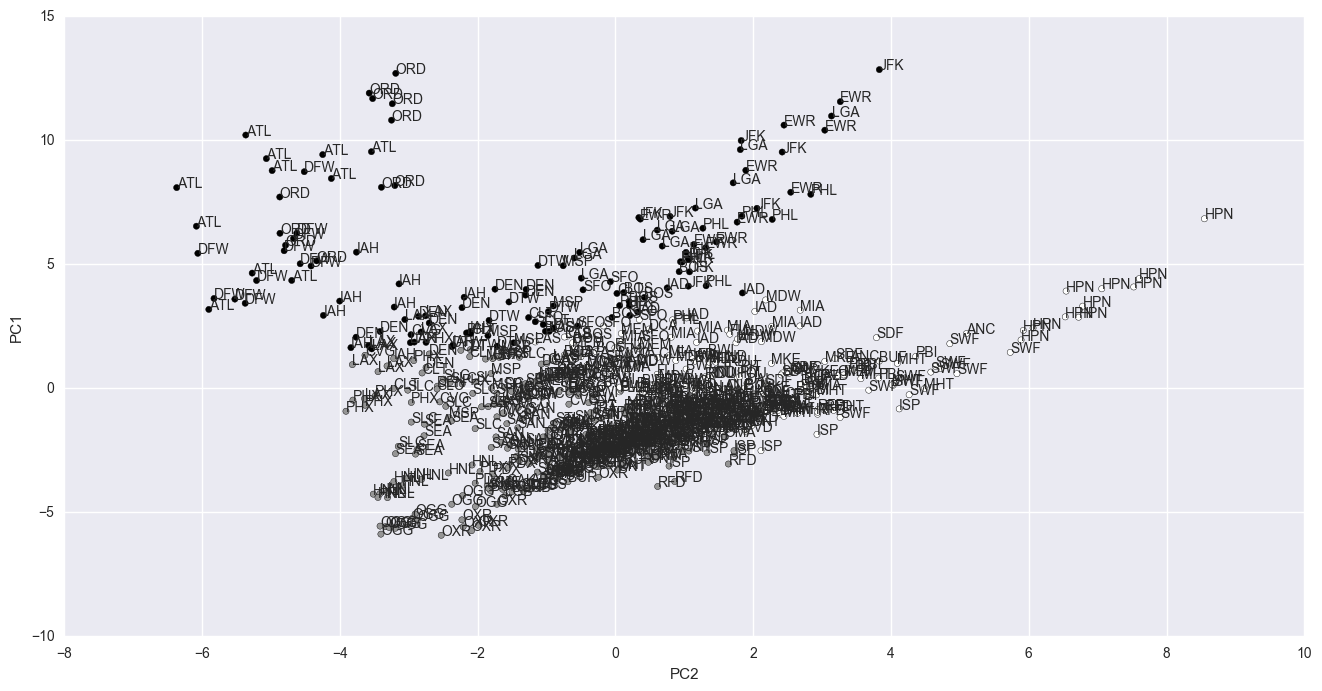

In [109]:
km_id = Xt.plot(kind='scatter', x='PC2',y='PC1', c=Xt.cluster.astype(np.float),figsize=(16,8))
for i, a in enumerate(airports['locid']):
    km_id.annotate(a, (Xt.iloc[i].PC2, Xt.iloc[i].PC1))

## DBSCAN 

In [137]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [138]:
db = DBSCAN(eps=0.3, min_samples=3)

In [139]:
db.fit(Xt)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    min_samples=3, n_jobs=1, p=None)

In [140]:
core_samples = db.core_sample_indices_
labels = db.labels_

In [141]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xt, labels))

Silhouette Coefficient: -0.021


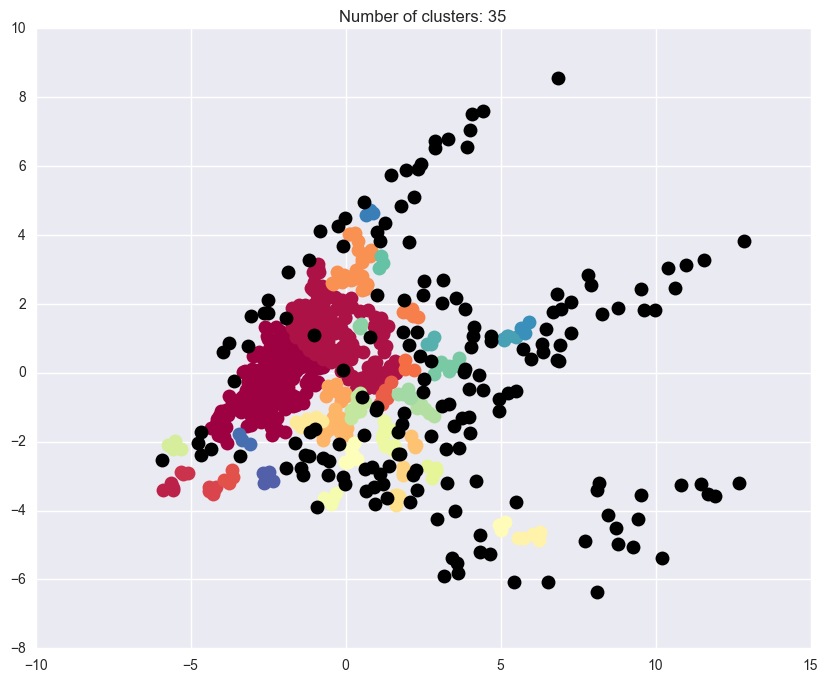

In [143]:
def plot_dbscan(db, Xt):
    fig = plt.figure(figsize=(10,8))
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=10)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=10)
        

    plt.title('Number of clusters: %d' % n_clusters_);
    
plot_dbscan(db, Xt)

## HIERARCHICAL 

In [114]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial import distance as ssd
from scipy.spatial.distance import pdist

In [115]:
Z = linkage(pdist(Xt), 'ward')

In [120]:
c, coph_dists = cophenet(Z, pdist(Xt))
c

0.70102250501712982

([], <a list of 0 Text xticklabel objects>)

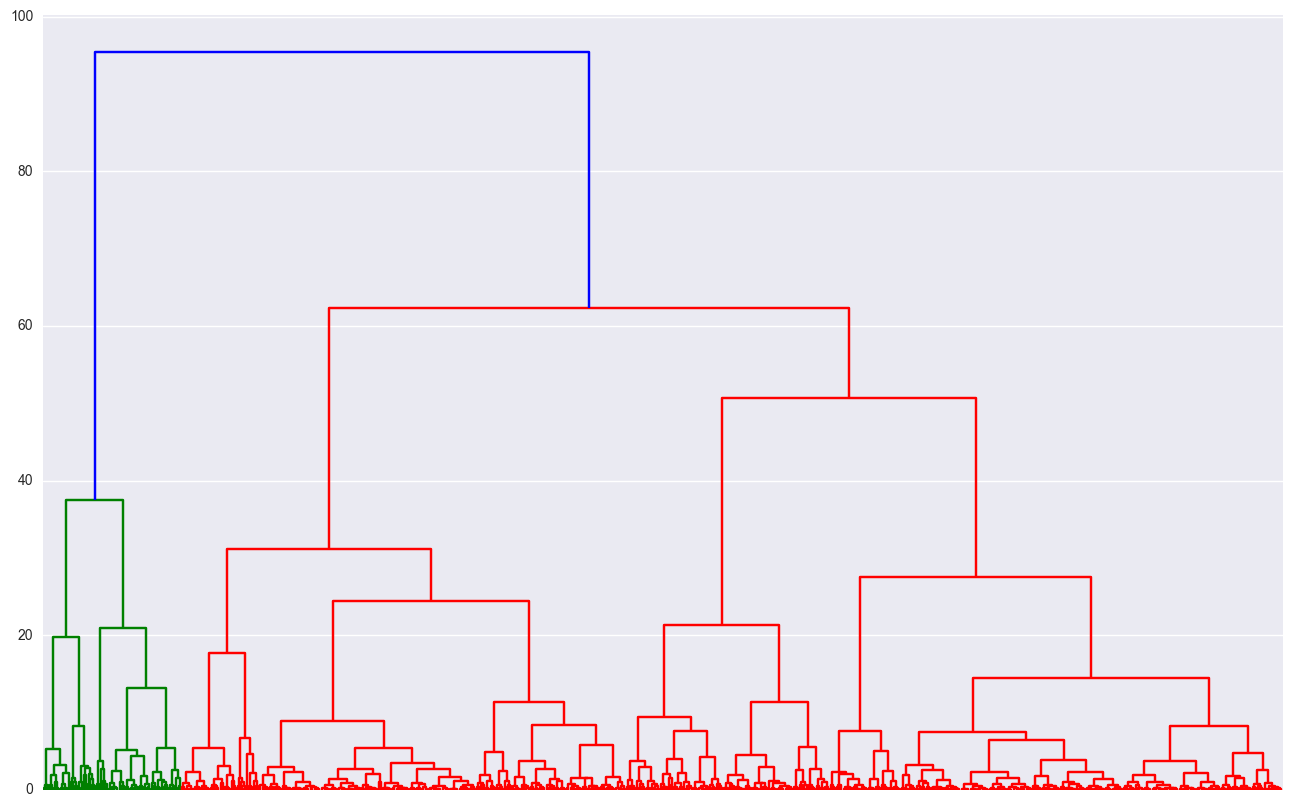

In [123]:
fig, ax = plt.subplots(figsize=(16,10))
dn = hierarchy.dendrogram(Z)
plt.xticks([])